# N-dimensional model for cubical persistence homology:
---
Murilo Henrique Gomes.

## Libraries and Functions:

### System:

In [ ]:
!pip install giotto-tda

In [ ]:
!pip install POT
!pip install gudhi
!pip install ripser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ripser: filename=ripser-0.6.4-cp310-cp310-linux_x86_64.whl size=686977 sha256=4ac161203b636232e960dcec23f40077b6c9f05c3d6bbfccdbc45b908df84db6
  Stored in directory: /root/.cache/pip/wheels/c5/f5/66/f41f708b049057431155934f74e20ca6001a085fcd2e615150
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=0a721727a2853c4eabddad75f0d8cb72499db9738b1760c0d4f9d0731acfa320
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc

In [ ]:
# Interactions with operational system:
import gc
import sys
import os
sys.path.append('path')

### Imports:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Computational performance analysis:
import time # tracking computation time
from tqdm.notebook import tqdm
tqdm.pandas()

# Image
import PIL # imaging library
import skimage.filters as filters # infer ISODATA thresholds from images
import cv2 as cv # binarize images and SIFT

In [ ]:
# Pre processing of topological data
import ripser
import TDAimgprocess as TIP # topological image modification and processing

In [ ]:

import gudhi
gudhi.persistence_graphical_tools._gudhi_matplotlib_use_tex=False
import sklearn

In [ ]:
from gudhi.sklearn.cubical_persistence import CubicalPersistence
from gudhi.representations import PersistenceImage, DiagramSelector

### Scripts:

In [ ]:
def randomPoints(number, interval):
  from random import randint
  points = []

  for i in range(number):
    points.append(tuple((randint(0,interval[0]), randint(0, interval[1]))))

  return points

In [ ]:
def augmentingImg(path, path_segm, index, thresh = 0,n_random = 30, pcc = 8, n_points = 8,radius = 1, METHOD = 'uniform', resize = (150, 150)):

  # Img in RGB
  original_image = cv.imread(path, cv.IMREAD_COLOR)
  original_image_rgb = cv.cvtColor(original_image, cv.COLOR_BGR2RGB)

  # Segmentation used to crop the image
  original_image_segm = cv.imread(path_segm, cv.IMREAD_GRAYSCALE)
  TIPgray = cv.threshold(original_image_segm, thresh, 255, cv.THRESH_BINARY)[1]

  TIPgray_int = TIPgray.astype(np.uint8)

  cont,_ = cv.findContours(TIPgray_int,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_NONE)

  cont_img = cv.drawContours(original_image_segm, cont, -1, 0)

  c = max(cont, key = cv.contourArea )
  x,y,v,h = cv.boundingRect(c)

  # First cleaning
  del original_image_segm
  del TIPgray
  del TIPgray_int
  del cont_img
  del c
  gc.collect()

  # Taking channels of color

  original_cropped = original_image_rgb[y:y+h,x:x+v]
  #grayscale = cv.cvtColor(original_cropped, cv.COLOR_RGB2GRAY)

  RBG_original_cropped = original_cropped.copy()
  HSV_original_cropped = cv.cvtColor(RBG_original_cropped, cv.COLOR_RGB2HSV)

  # Spliting in to separeted channels
  (R, G, B) = cv.split(RBG_original_cropped)
  (H, S, V) = cv. split(HSV_original_cropped)

  # S = 255-S #taken the negative

  # Second cleaning
  del x
  del y
  del v
  del h
  del original_cropped
  del RBG_original_cropped
  del HSV_original_cropped
  gc.collect()

  # random points:

  points = randomPoints(n_random, resize)

  stacked_img = np.array([R,G,B,H,S,V])

  resize_stacked = np.array([cv.resize(stacked_img[i], resize, interpolation= cv.INTER_LINEAR) for i in range(stacked_img.shape[0])])
  resize_stacked = [points, resize_stacked]

  # Third cleaning
  del points
  #del grayscale
  #del img_gray
  del R
  del G
  del B
  del H
  del S
  del V
  del stacked_img
  gc.collect()

  return resize_stacked

In [ ]:
def partitionsWithIntersection(a,n,k,m):
  R=range(len(a)+1-n)
  return [[r[i:i+n] for r in a[j:j+n]] for i in R for j in R if (i < k < (i+(n//4))) and (j < m < (j+(n//4)))]

In [ ]:
def partitionToVectorSpace(*squareMatrix): # Aqui pode ser um ponto de remodelagem

  from sklearn.preprocessing import MinMaxScaler

  transformer = MinMaxScaler().fit(np.array(*squareMatrix))
  Vectors_normalize = transformer.transform(np.array(*squareMatrix))

  return Vectors_normalize

In [ ]:
def vectorSpaceToPersistenceDiagram(n_vectors):

  distance = np.amax(n_vectors) - np.amin(n_vectors)

  skeleton = gudhi.RipsComplex(points=n_vectors, max_edge_length=(distance+1)/2)

  simplex_tree = skeleton.create_simplex_tree(max_dimension=4)

  pd = np.array([simplex_tree.persistence_intervals_in_dimension(i) for i in range(simplex_tree.dimension()) if simplex_tree.persistence_intervals_in_dimension(i).shape[0] != 0], dtype=object)

  return pd

In [ ]:
def mapMatrix_sub_v2(multichannel_squareMatrix):

  vectors = []

  for i in range(multichannel_squareMatrix.shape[1]):
    for j in range(multichannel_squareMatrix.shape[2]):
      v = []
      v.append(i)
      v.append(j)
      for k in range(multichannel_squareMatrix.shape[0]):
        v.append(multichannel_squareMatrix[k][i][j])
      vectors.append(v)

  return np.array(vectors)

In [ ]:
def oneBarCodeConversion(simplex_tree):
  simplex_tree.compute_persistence()
  aux = []
  for i in range(simplex_tree.dimension()):
    if simplex_tree.persistence_intervals_in_dimension(i).shape[0] != 0:
      for birthdeath in simplex_tree.persistence_intervals_in_dimension(i):
        aux.append(birthdeath)

  del simplex_tree
  gc.collect()

  return np.array(aux)

In [ ]:
def channelsToBarCode(img_channels):

  barcode = []

  for j in range(img_channels.shape[1]):
  #c = np.array([img_channels[i][0] for i in range(img_channels.shape[0])] )
  #print(c.shape)
  #print(mapMatrix_sub(c).shape)
    aux = np.array([img_channels[i][0] for i in range(img_channels.shape[0])])
    skeleton = gudhi.RipsComplex(points = mapMatrix_sub_v2( aux ),
                                 max_edge_length = (np.amax(aux) - np.amin(aux)+1)/2)

    del aux
    gc.collect()

    simplex_tree = skeleton.create_simplex_tree(max_dimension=4)
    del skeleton
    gc.collect()

    barcode.append(oneBarCodeConversion(simplex_tree))

    del simplex_tree
    gc.collect()

  return np.array(barcode)

In [ ]:
def channelsToDiagrams(img_channels, filtration):

  if filtration == 'Radial':
    from gtda.images import RadialFiltration
    Filtration = RadialFiltration(center=np.array([0,0]))
  if filtration == 'Density':
    from gtda.images import DensityFiltration
    Filtration = DensityFiltration()


  from gtda.homology import CubicalPersistence
  cubicalPersistence = CubicalPersistence(homology_dimensions=(0,1,2,3,4),
                                          n_jobs = -1)

  diagrams = []

  for j in range(img_channels.shape[1]):
  #c = np.array([img_channels[i][0] for i in range(img_channels.shape[0])] )
  #print(c.shape)
  #print(mapMatrix_sub(c).shape)
    aux = np.array([img_channels[i][j] for i in range(img_channels.shape[0])])
    #print(mapMatrix_sub_v2( aux ).shape)
    map_filtration = Filtration.fit_transform([mapMatrix_sub_v2( aux )])

    del aux
    gc.collect()

    diagm_filtration = cubicalPersistence.fit_transform(map_filtration)
    del map_filtration
    gc.collect()

    diagrams.append(diagm_filtration)

  del Filtration
  del cubicalPersistence
  del diagm_filtration
  gc.collect()

  return diagrams

In [ ]:
def imgDistanceMatrix(diagrams, distance, q):

  from pandas.core.indexing import length_of_indexer
  from gtda.diagrams import PairwiseDistance

  if distance == 'bottleneck':
    dist = PairwiseDistance(metric = distance)
  else:
    dist = PairwiseDistance(metric = distance, metric_params = q)

  dist_ab = lambda a, b: dist.fit(a) and dist.transform(b)[0][0]

  length = len(diagrams)
  dm = np.zeros((length,length))
  for i in tqdm(range(length), desc = 'Progress bar'):
    for j in range(0,i+1):
      dm[i,j] = dist_ab(diagrams[i],diagrams[j])
      dm[j,i] = dm[i,j]

  return dm

In [ ]:
def searchRegionDict(dict_, nth_index):
  count = 0
  for key in dict_.keys():
    count += len(dict_[key])
    if nth_index < count:
      return key
    count += 1

In [ ]:
def distinctImageRegions(channels,pointsDistinct,size_partition):
  from scipy.ndimage import affine_transform

  nimages = channels.shape[0]
  img_height, img_width = 150, 150
  bg_val = 0 # Some flag value indicating the background.

  #images = augmented['mel'].values[1][1].copy()

  l = (size_partition)//2

  for channel in channels:
    for point in pointsDistinct:
      channel = cv.rectangle(channel, (point[0]-l, point[1]+l),
                            (point[0]+l, point[1]-l), (255, 255, 255), 2)

  stacked_height = int(img_height)
  stacked_width  = int(img_width + (nimages-1)*img_width/2) - 225
  stacked = np.full((stacked_height, stacked_width), bg_val)

  # Affine transform matrix.
  T = np.array([[1.55,-1.55],
                [0, 1.55]])

  for i in range(nimages):
      # The first image will be right most and on the "bottom" of the stack.
      o = (nimages-i-1) * img_width/2
      out = affine_transform(channels[i], T, offset=[o,-o],
                            output_shape=stacked.shape, cval=bg_val)
      stacked[out != bg_val] = out[out != bg_val]

  fig, ax = plt.subplots(1,2, figsize = (7,3),gridspec_kw={'width_ratios': [3, 1]})
  ax[0].imshow(stacked, cmap=plt.cm.viridis,interpolation='none')
  ax[0].axis('off')

  ax[1].imshow(channels[:3].T,interpolation='none')
  ax[1].axis('off')
  #plt.tight_layout()
  plt.show()

In [ ]:
def imagePersistenceDiagrams(img, metric_params, size_partition = 10, type_diagram = 'barcode',n_dim = 4, filtration = 'Radial', distance = 'wasserstein'):

  from gtda.homology import CubicalPersistence
  cubicalPersistence = CubicalPersistence(homology_dimensions=(0,1,2,3,4),
                                          n_jobs = -1)

  points = img[0]
  channels = img[1]

  # print(points)
  # print(channels)

  partitions = []
  dict_pointPartitions = {}
  for i in range(len(channels)):
    #print(channels[i])
    aux = []
    for point in points:
      dict_pointPartitions[tuple((point[0], point[1]))] = []
      for submatrix in partitionsWithIntersection(channels[i],size_partition,point[0], point[1]):
        aux.append(submatrix)
      dict_pointPartitions[tuple((point[0], point[1]))].append(np.array(aux)) # não preciso armazenar os dados, só o número de entradas.
    partitions.append(aux)

  partitions = np.array(partitions)

  del channels
  del aux
  gc.collect()

  #print(partitions.shape)
  #print(dict_pointPartitions.keys())

  n_channels = partitions.shape[0]
  n_partitions = partitions.shape[1]

  vectorSpaces = np.asarray([[partitionToVectorSpace(partitions[i][j]) for j in range(n_partitions)] for i in range(n_channels)])
  del partitions
  gc.collect()

  #print(vectorSpaces.shape)
  #print(vectorSpaces[0].shape)

  diagrams = channelsToDiagrams(vectorSpaces, filtration)
  del vectorSpaces
  gc.collect()

  #print(len(points))
  if len(points) == 0:
    dm = np.zeros((1, 1))
    # fig, ax = plt.subplots()
    # sn.heatmap(dm)
    # plt.show()

    distance = np.amax(dm) - np.amin(dm)
    rips_complex = gudhi.RipsComplex(distance_matrix=dm, max_edge_length=distance)
    simplex_tree_1 = rips_complex.create_simplex_tree(max_dimension=n_dim)

    if type_diagram == 'barcode':
      diagram = simplex_tree_1.persistence()
    else:
      simplex_tree_1.compute_persistence()
      diagram = {}
      for i in range(n_dim):
        diagram[i] = simplex_tree_1.persistence_intervals_in_dimension(i)

    # gudhi.plot_persistence_barcode(BarCode_1);
    # plt.tight_layout()
    # plt.show()

    return diagram
  else:

    dm = imgDistanceMatrix(diagrams, distance, metric_params)
    del diagrams
    gc.collect()

    # fig, ax = plt.subplots()
    # sn.heatmap(dm)
    # plt.show()

    distance = np.amax(dm) - np.amin(dm)
    rips_complex = gudhi.RipsComplex(distance_matrix=dm, max_edge_length=distance)
    simplex_tree_1 = rips_complex.create_simplex_tree(max_dimension= n_dim)

    if type_diagram == 'barcode':
      diagram = simplex_tree_1.persistence()
    else:
      simplex_tree_1.compute_persistence()
      diagram = {}
      for i in range(n_dim):
        diagram[i] = simplex_tree_1.persistence_intervals_in_dimension(i)

    # gudhi.plot_persistence_barcode(BarCode_1);
    # plt.tight_layout()
    # plt.show()

    del dm
    gc.collect()

    return diagram

      # pointsDistinct = []
      # for nth_index in mostDistinct_v2(dm):
      #   pointsDistinct.append(searchRegionDict(dict_pointPartitions, nth_index))

      # #del dm
      # #gc.collect()

      # # displaying the title
      # import plotly.graph_objects as go
      # from plotly.subplots import make_subplots

      # for idx in mostDistinct_v2(dm):

      #   fig = go.Figure(cubicalPersistence.plot(diagrams[idx]))

      #   fig.update_layout(
      #       font_family="Courier New",
      #       font_color="blue",
      #       title_font_family="Times New Roman",
      #       title_font_color="black",
      #       legend_title_font_color="green",
      #       title={
      #           'text': str(idx)+'º index is a'+"very distinct diagram in First melanoma sample",
      #           'y':0.9,
      #           'x':0.5,
      #           'xanchor': 'center',
      #           'yanchor': 'top'}
      #   )
      #   fig.update_xaxes(title_font_family="Arial")
      #   fig.write_image("path"+ str(idx) + ".png")

      # distinctImageRegions(channels,pointsDistinct,size_partition)



In [ ]:
def visualization(path, path_segm, index, thresh = 0, pcc = 8, n_points = 8, radius = 8,
                  METHOD = 'uniform', resize = (150, 150), size_partition = 10,
                  type_diagram = 'barcode', n_dim = 4, filtration = 'Radial',
                  distance = 'wasserstein', metric_params = {'p': 2, 'delta': 0.01}):

  image = cv.imread(path)
  imgRGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)

  if metric_params == None:
    images_dir = 'path' + os.sep + filtration + os.sep + distance
  else:
    images_dir = 'path' + os.sep + filtration + os.sep + distance + os.sep + 'p=' + str(metric_params['p'])

  if os.path.isdir(images_dir) == True:

    img = augmentingImg(path, path_segm, index, thresh = 0, pcc = 8, n_points = 8,radius = 1, METHOD = 'uniform', resize = (150, 150))
    diagram = imagePersistenceDiagrams(img, metric_params, size_partition,
                                       type_diagram = type_diagram, n_dim = n_dim,
                                       distance = distance)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    gudhi.plot_persistence_barcode(diagram,axes=axes[0], legend = True)

    axes[1].imshow(imgRGB,interpolation='none')
    axes[1].axis('off')
    axes[1].set_title(f"RGB image of {index}",fontsize=12)

    plt.tight_layout()
    plt.savefig(f"{images_dir}/label{index}.png")
    plt.close()

    del img
    del diagram
    del fig
    del axes
    gc.collect()

  else:

    os.makedirs(images_dir)

    img = augmentingImg(path, path_segm, index, thresh = 0, pcc = 8, n_points = 8,radius = 1, METHOD = 'uniform', resize = (150, 150))
    diagram = imagePersistenceDiagrams(img, metric_params, size_partition,
                                       type_diagram = type_diagram, n_dim = n_dim,
                                       distance = distance)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    gudhi.plot_persistence_barcode(diagram,axes=axes[0], legend = True)

    axes[1].imshow(imgRGB,interpolation='none')
    axes[1].axis('off')
    axes[1].set_title(f"RGB image of {index}",fontsize=12)

    plt.tight_layout()
    plt.savefig(f"{images_dir}/label{index}.png")
    plt.close()

    del img
    del diagram
    del fig
    del axes
    gc.collect()

In [ ]:
def persistenceDiagram(path, path_segm, index, thresh = 0, pcc = 8, n_points = 8, radius = 8,
                  METHOD = 'uniform', resize = (150, 150), size_partition = 10,
                  type_diagram = 'barcode', n_dim = 4, filtration = 'Radial',
                  distance = 'wasserstein', metric_params = {'p': 2, 'delta': 0.01}):

  img = augmentingImg(path, path_segm, index, thresh = 0, pcc = 8, n_points = 8,radius = 1, METHOD = 'uniform', resize = (150, 150))
  diagram = imagePersistenceDiagrams(img, metric_params, size_partition,
                                       type_diagram = type_diagram, n_dim = n_dim,
                                       distance = distance)

  del img
  gc.collect()

  return diagram

In [ ]:
def classToDistanceMatrix(dataframe, classes, n_dim, distance = 'bottleneck', metric_params = {'p':2}):

  persistenceOfClass = {}

  for class_ in tqdm(classes):
    aux = dataframe.loc[dataframe['classes'] == class_]['persistence'].values
    persistenceOfClass[class_] = {}
    #print(len(aux))
    for k in range(n_dim):
      dm_aux = np.zeros((len(aux),len(aux)))
      for i in range(len(aux)):
        for j in range(len(aux)):
          #print(class_, k, i, j)
          if distance == 'bottleneck':
            dm_aux[i][j] = gudhi.hera.bottleneck_distance(aux[i][k],aux[j][k])
          elif distance == 'wasserstein':
            dm_aux[i][j] = gudhi.hera.wasserstein_distance(aux[i][k],aux[j][k], order = metric_params['p'], internal_p = 2)
          else:
            print('Invalid distance parameter.')
            break
      persistenceOfClass[class_][k] = dm_aux
      #print(persistenceOfClass)

  del dataframe
  gc.collect()

  return persistenceOfClass

In [ ]:
def distancesToBarcodes(dict_, n_dim = 4):

  barcodes = {}

  for class_ in dict_.keys():
    barcodes[class_] = {}
    for dim in dict_[class_].keys():
      barcodes[class_][dim] = {}
      dm = dict_[class_][dim]

      distance = np.amax(dm) - np.amin(dm)
      rips_complex = gudhi.RipsComplex(distance_matrix=dm, max_edge_length=distance)
      simplex_tree_1 = rips_complex.create_simplex_tree(max_dimension= n_dim)

      diagram = {}
      simplex_tree_1.compute_persistence()
      for i in range(n_dim):
        diagram[i] = simplex_tree_1.persistence_intervals_in_dimension(i)

      barcodes[class_][dim] = diagram

  del dict_
  gc.collect()

  return barcodes

In [ ]:
def distancesOfClasses(dict_, distance = 'bottleneck', metric_params = {'p':2}):
  distanceOfClass = {}

  for class_i in dict_.keys():
    for class_j in dict_.keys():
      distanceOfClass[tuple((class_i, class_j))] = {}
      aux = 0
      for dim in dict_[class_i].keys():
        sum = 0
        for i in dict_[class_i][dim].keys():
          if distance == 'bottleneck':
            sum += gudhi.hera.bottleneck_distance(dict_[class_i][dim][i],
                                               dict_[class_j][dim][i])
          elif distance == 'wasserstein':
            sum += gudhi.hera.wasserstein_distance(dict_[class_i][dim][i],
                                               dict_[class_j][dim][i],
                                               order = metric_params['p'],
                                               internal_p = 2 )
          else:
            print('Invalid distance parameter.')
            break
        aux += sum
      distanceOfClass[tuple((class_i, class_j))] = aux

  del aux
  del sum
  del dict_
  gc.collect()

  return distanceOfClass

In [ ]:
def persistenceDiagramasOfImagesToDiferenceOfClasses(dataframe, classes, n_dim, distance = 'bottleneck', metric_params = {'p':2}):

  distancesMatrix = classToDistanceMatrix(df, df['classes'].unique(), n_dim = 4, distance = distance, metric_params = metric_params)

  barcodes = distancesToBarcodes(distancesMatrix)

  distances = distancesOfClasses(barcodes,distance = distance, metric_params = metric_params)

  df_dist = pd.DataFrame(list(distances.items()),columns = ['classes', str(distance)])

  df_dist = df_dist.set_index('classes')

  index = df_dist.index
  index = pd.MultiIndex.from_tuples(index)

  df_dist = df_dist.reindex(index)
  df_dist = df_dist.unstack()

  if distance == 'bottleneck':
    name = distance
  elif distance == 'wasserstein':
    name = distance + ' com p=' + str(metric_params['p'])

  plt.figure(figsize=[5,4])
  ax = sns.heatmap(
      df_dist,
      xticklabels=['akiec', 'bcc','bkl','df', 'mel','nv','vasc'],
      yticklabels=True)
  # X - Y axis labels
  ax.set_ylabel('')
  ax.set_xlabel('')
  # Rotate tick labels
  locs, labels = plt.xticks()
  plt.setp(labels, rotation=0)
  locs, labels = plt.yticks()
  plt.setp(labels, rotation=0)
  plt.title('Distância entre as classes da base de dados\n utilizando a distância ' + name, size=11)
  plt.tight_layout()
  plt.savefig("distanceClasses" +  name + ".png")
  plt.show()


  return df_dist

## Data acessing:

In [ ]:
path = 'path'

data = pd.read_csv(path + '/data_join', index_col = 0)
data = data.rename(
    columns=({ 'caminho': 'path', 'caminho_tip': 'tip_path', 'caminho_segmantation': 'segmen_path'})
)

# change strings names of paths
data = data.replace('path', path, regex=True)

data.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,tip_path,segmen_path
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,vidir_molemax,/content/gdrive/MyDrive/Iniciação Científic...,/content/gdrive/MyDrive/Iniciação Científic...,/content/gdrive/MyDrive/Iniciação Científic...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
 8   path          10015 non-null  object 
 9   tip_path      10015 non-null  object 
 10  segmen_path   10015 non-null  object 
dtypes: float64(1), object(10)
memory usage: 938.9+ KB


In [ ]:
classes = data['dx'].unique()
print(classes)

['nv' 'mel' 'bkl' 'df' 'akiec' 'bcc' 'vasc']


## Pre processing:

### Take a sample:

In [ ]:
samples = data.groupby('dx').apply(lambda x: x.sample(15,replace=True, random_state=42))

### Computing homology pipeline:

### Visualization:

In [ ]:
samples.progress_apply(lambda x: visualization(x.path, x.segmen_path,x.name, thresh = 0, pcc = 8, n_points = 8,radius = 1, METHOD = 'uniform', filtration = 'Dilation', distance = 'wasserstein', metric_params = {'p':2}), axis = 1)

  0%|          | 0/14 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/29 [00:00<?, ?it/s]

dx         
akiec  2675    None
       7075    None
bcc    2044    None
       7996    None
bkl    7864    None
       9990    None
df     9248    None
       4746    None
mel    8920    None
       9930    None
nv     1255    None
       7812    None
vasc   7751    None
       6970    None
dtype: object

### Representation of classes:

In [ ]:
inicio = time.time()
wassersteinP2_v1 = samples.progress_apply(lambda x: persistenceDiagram(x.path, x.segmen_path,x.name, thresh = 0, pcc = 8, n_points = 8,radius = 1,
                                                                 METHOD = 'uniform', type_diagram = 'persistence diagram', n_dim = 4,
                                                                 filtration = 'Density', distance = 'wasserstein', metric_params = {'p':2}), axis = 1)
fim = time.time()
print(fim - inicio)

  0%|          | 0/105 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/29 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/23 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/30 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/29 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/22 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/23 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/22 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/23 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/30 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/29 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/30 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/23 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/22 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/23 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/23 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/29 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/29 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/23 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/24 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/23 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/28 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/30 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/22 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/21 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/29 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/27 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/22 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/26 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

Progress bar:   0%|          | 0/25 [00:00<?, ?it/s]

2236.28955578804


In [ ]:
df = wassersteinP2_v1.to_frame(name = 'persistence').reset_index(names = ['classes', 'index']).set_index(['index'])

In [ ]:
df_dilation = wassersteinP2_v1.to_frame(name = 'persistence').reset_index(names = ['classes', 'index']).set_index(['index'])

  0%|          | 0/7 [00:00<?, ?it/s]

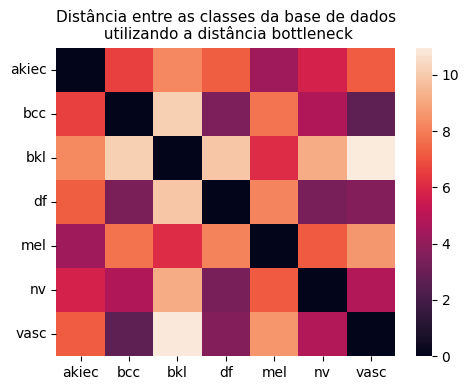

In [ ]:
df_bottleneck = persistenceDiagramasOfImagesToDiferenceOfClasses(df, df['classes'].unique(), n_dim = 4)

  0%|          | 0/7 [00:00<?, ?it/s]

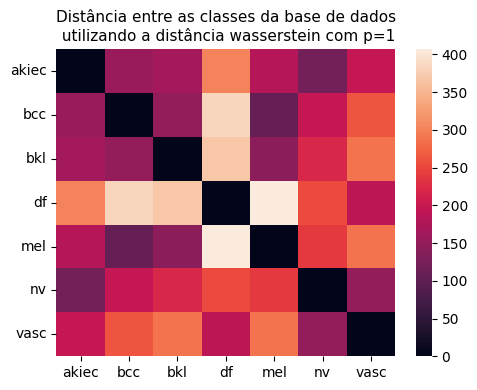

In [ ]:
df_wassersteinP1 = persistenceDiagramasOfImagesToDiferenceOfClasses(df, df['classes'].unique(), n_dim = 4, distance = 'wasserstein', metric_params = {'p': 1})

  0%|          | 0/7 [00:00<?, ?it/s]

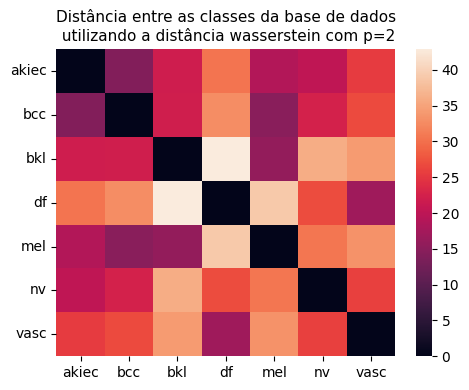

In [ ]:
df_wassersteinP2 = persistenceDiagramasOfImagesToDiferenceOfClasses(df, df['classes'].unique(), n_dim = 4, distance = 'wasserstein', metric_params = {'p': 2})

  0%|          | 0/7 [00:00<?, ?it/s]

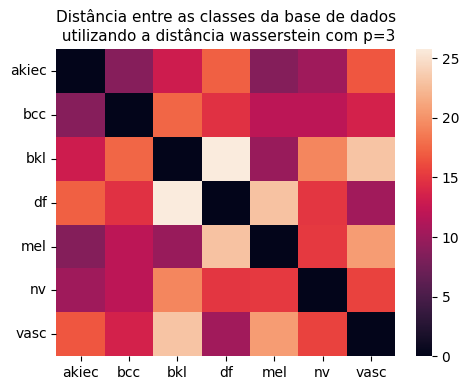

In [ ]:
df_wassersteinP3 = persistenceDiagramasOfImagesToDiferenceOfClasses(df, df['classes'].unique(), n_dim = 4, distance = 'wasserstein', metric_params = {'p': 3})

  0%|          | 0/7 [00:00<?, ?it/s]

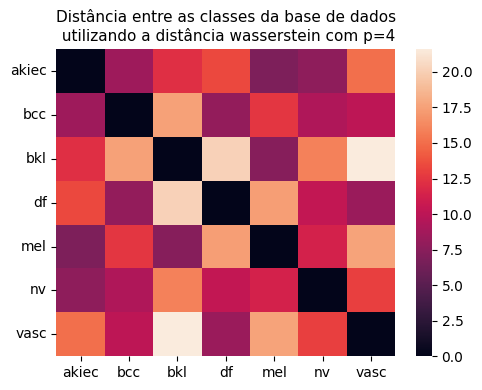

In [ ]:
df_wassersteinP4 = persistenceDiagramasOfImagesToDiferenceOfClasses(df, df['classes'].unique(), n_dim = 4, distance = 'wasserstein', metric_params = {'p': 4})